### Notebook
- Creates boxplots from Fig. S6

In [1]:
import pandas as pd
import numpy as np
import os

from scipy.stats import mannwhitneyu

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

### 0. Load data

In [4]:
print('Loading confidently typed patients')
confident_patients_I = pd.read_csv('../data/confidently_typed_patients.class_i.csv', index_col=0).index.values
confident_patients_II = pd.read_csv('../data/confidently_typed_patients.class_ii.csv', index_col=0).index.values

Loading confidently typed patients


In [2]:
print('Loading affinities')
driver_phbr_affinities_I = pd.read_csv('../data/driver_mut.class_i.affinities.tsv.gz', sep='\t', index_col=0)
driver_phbr_affinities_II = pd.read_csv('../data/driver_mut.class_ii.affinities.tsv.gz', sep='\t', index_col=0)

Loading affinities


In [5]:
print('Loading mutations')
binary_mut_df = pd.read_csv('../data/patient_binary_driver.matrix', sep='\t', index_col=0)

mut_patients, mutations = zip(*list(binary_mut_df[binary_mut_df == 1].stack().index))
mut_df = pd.DataFrame({'driver_mut': mutations}, index=mut_patients)

mut_df_I = mut_df[mut_df.index.isin(confident_patients_I)]
mut_df_II = mut_df[mut_df.index.isin(confident_patients_II)]

Loading mutations


### 1. Prepare data

In [6]:
# Add PHBR scores 
mut_df_I['scores'] = [driver_phbr_affinities_I.loc[mut_df_I.index.values[i], mut_df_I['driver_mut'].values[i]] for i in range(len(mut_df_I))]

phbr_ii_scores = []

for i in range(len(mut_df_II)):
    patient = mut_df_II.index.values[i]
    mutation = mut_df_II['driver_mut'].values[i]
    
    if patient in driver_phbr_affinities_II.index:
        phbr_ii_scores.append(driver_phbr_affinities_II.loc[patient, mutation])
    else:
        phbr_ii_scores.append(np.nan)
        
mut_df_II['scores'] = phbr_ii_scores
mut_df_II.dropna(inplace=True)

len(mut_df_I), len(mut_df_II)

/cellar/users/andreabc/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/cellar/users/andreabc/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/cellar/users/andreabc/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.

(6499, 6000)

In [11]:
# Add clinical data
tcga_clinical = pd.read_csv('../data/all_clinical_tcga.txt.gz', sep='\t', index_col='bcr_patient_barcode')
tcga_clinical['age_at_initial_pathologic_diagnosis'] = pd.to_numeric(tcga_clinical['age_at_initial_pathologic_diagnosis'], errors='coerce')
tcga_clinical.dropna(subset=['age_at_initial_pathologic_diagnosis'], inplace=True)

# how many patients have clinical info?
before_count = len(set(mut_df_I.index.values))
mut_df_I = mut_df_I[mut_df_I.index.isin(tcga_clinical.index)]
after_count = len(set(mut_df_I.index.values))
print('Dropped {} patients - no clinical info'.format(before_count-after_count))

# add sex/age columns 
mut_df_I['age'] = [tcga_clinical.loc[x,'age_at_initial_pathologic_diagnosis'] for x in mut_df_I.index.values]
mut_df_I['sex'] = [tcga_clinical.loc[x,'gender'].lower() for x in mut_df_I.index.values]
mut_df_I['disease'] = [tcga_clinical.loc[x,'disease'].split('-')[1] for x in mut_df_I.index.values]
mut_df_I.head(2)

Dropped 0 patients - no clinical info


,driver_mut,scores,age,sex,disease
TCGA-85-8580,M_TP53_R249S,0.120879,52.0,female,LUSC
TCGA-A5-A0GV,M_PTEN_R130G,3.524218,67.0,female,UCEC


In [12]:
# how many patients have clinical info?
before_count = len(set(mut_df_II.index.values))
mut_df_II = mut_df_II[mut_df_II.index.isin(tcga_clinical.index)]
after_count = len(set(mut_df_II.index.values))
print('Dropped {} patients - no clinical info'.format(before_count-after_count))

# add sex/age columns 
mut_df_II['age'] = [tcga_clinical.loc[x,'age_at_initial_pathologic_diagnosis'] for x in mut_df_II.index.values]
mut_df_II['sex'] = [tcga_clinical.loc[x,'gender'].lower() for x in mut_df_II.index.values]
mut_df_II['disease'] = [tcga_clinical.loc[x,'disease'].split('-')[1] for x in mut_df_II.index.values]
mut_df_II.head(2)

Dropped 0 patients - no clinical info


,driver_mut,scores,age,sex,disease
TCGA-A5-A0GV,M_PTEN_R130G,11.085044,67.0,female,UCEC
TCGA-A5-A0GV,M_CTNNB1_D32N,2.904973,67.0,female,UCEC


In [16]:
# add categorical age

young_thresh = 52 # 30th percentile: 52
old_thresh = 68   # 70th percentile: 68

mut_df_I['age_categorical_3070'] = pd.cut(mut_df_I['age'], [0, young_thresh, old_thresh, mut_df_I['age'].max()], labels=['younger', 'middle', 'older'])
mut_df_II['age_categorical_3070'] = pd.cut(mut_df_II['age'], [0, young_thresh, old_thresh, mut_df_II['age'].max()], labels=['younger', 'middle', 'older'])

##### 1A. Remove sex-specific cancers for sex-analysis

In [17]:
sex_specific_diseases = ['UCS', 'PRAD', 'BRCA', 'UCEC', 'CESC', 'TGCT', 'OV']

mut_I_rm_sex_specific = mut_df_I[~mut_df_I['disease'].isin(sex_specific_diseases)]
mut_II_rm_sex_specific = mut_df_II[~mut_df_II['disease'].isin(sex_specific_diseases)]

### 3. Plot

Saving to ../figures/S6_phbr_boxplots.no_expression_filter.pdf


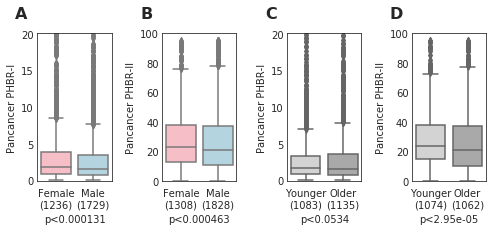

In [18]:
plt.figure(figsize=(7,3))

###########################
# A. Pancancer sex PHBR-I #
###########################
plt.subplot(1,4,1)

p = mannwhitneyu(mut_I_rm_sex_specific[mut_I_rm_sex_specific['sex']=='female'].scores.values, mut_I_rm_sex_specific[mut_I_rm_sex_specific['sex']=='male'].scores.values).pvalue
ax = sns.boxplot(x='sex', y='scores', data=mut_I_rm_sex_specific, order=['female', 'male'], palette=['lightpink', 'lightblue'])

plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('Pancancer PHBR-I')
plt.xticks([0,1], ['Female\n({})'.format(len(set(mut_I_rm_sex_specific[mut_I_rm_sex_specific['sex']=='female'].index))), 
                   'Male\n({})'.format(len(set(mut_I_rm_sex_specific[mut_I_rm_sex_specific['sex']=='male'].index)))])
plt.ylim(-0.1,20.1)
ax.tick_params(axis='y', pad=0)

plt.text(-0.3, 1.1, 'A', transform=ax.transAxes, fontsize=16,  weight='bold')

############################
# B. Pancancer sex PHBR-II #
############################
plt.subplot(1,4,2)

p = mannwhitneyu(mut_II_rm_sex_specific[mut_II_rm_sex_specific['sex']=='female'].scores.values, mut_II_rm_sex_specific[mut_II_rm_sex_specific['sex']=='male'].scores.values).pvalue
ax = sns.boxplot(x='sex', y='scores', data=mut_II_rm_sex_specific, order=['female', 'male'], palette=['lightpink', 'lightblue'])

plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('Pancancer PHBR-II')
plt.xticks([0,1], ['Female\n({})'.format(len(set(mut_II_rm_sex_specific[mut_II_rm_sex_specific['sex']=='female'].index))), 
                   'Male\n({})'.format(len(set(mut_II_rm_sex_specific[mut_II_rm_sex_specific['sex']=='male'].index)))])
plt.ylim(-0.1,100.1)
ax.tick_params(axis='y', pad=0)

plt.text(-0.3, 1.1, 'B', transform=ax.transAxes, fontsize=16,  weight='bold')

###########################
# C. Pancancer age PHBR-I #
###########################
plt.subplot(1,4,3)

p = mannwhitneyu(mut_df_I[mut_df_I['age_categorical_3070']=='younger'].scores.values, mut_df_I[mut_df_I['age_categorical_3070']=='older'].scores.values).pvalue
ax = sns.boxplot(x='age_categorical_3070', y='scores', data=mut_df_I, order=['younger', 'older'], palette=['lightgrey', 'darkgrey'])

plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('Pancancer PHBR-I')
plt.xticks([0,1], ['Younger\n({})'.format(len(set(mut_df_I[mut_df_I['age_categorical_3070']=='younger'].index))), 
                   'Older\n({})'.format(len(set(mut_df_I[mut_df_I['age_categorical_3070']=='older'].index)))])
plt.ylim(-0.1,20.1)
ax.tick_params(axis='y', pad=0)

plt.text(-0.3, 1.1, 'C', transform=ax.transAxes, fontsize=16,  weight='bold')

############################
# D. Pancancer age PHBR-II #
############################
plt.subplot(1,4,4)

p = mannwhitneyu(mut_df_II[mut_df_II['age_categorical_3070']=='younger'].scores.values, mut_df_II[mut_df_II['age_categorical_3070']=='older'].scores.values).pvalue
ax = sns.boxplot(x='age_categorical_3070', y='scores', data=mut_df_II, order=['younger', 'older'], palette=['lightgrey', 'darkgrey'])

plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('Pancancer PHBR-II')
plt.xticks([0,1], ['Younger\n({})'.format(len(set(mut_df_II[mut_df_II['age_categorical_3070']=='younger'].index))), 
                   'Older\n({})'.format(len(set(mut_df_II[mut_df_II['age_categorical_3070']=='older'].index)))])
plt.ylim(-0.1,100.1)
ax.tick_params(axis='y', pad=0)

plt.text(-0.3, 1.1, 'D', transform=ax.transAxes, fontsize=16,  weight='bold')

# Save
plt.tight_layout()

savepath = '../figures/S6_phbr_boxplots.no_expression_filter.pdf'
print('Saving to {}'.format(savepath))
plt.savefig(savepath, bbox_inches='tight')
plt.show()